## Nov 17nd - Segmentation Task
- Use the full training set and full testing set
- Implement gaussian blur and color jitting to training dataset

In [1]:
import os
import json
import torch
import random
import cv2
import math
import numpy as np
import torchvision
from pathlib import Path
from torch import nn
from torch import optim
import torch.utils.data as Data
from torch.utils.data import Dataset
from torch.nn.utils.rnn import pad_sequence
from torch.nn import functional as F
from torchvision import models, transforms
import matplotlib.pyplot as plt 
import matplotlib
import tqdm
from sklearn.metrics import jaccard_score

%matplotlib inline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tau = 5

## Data Preparation

In [2]:
data_path = Path("C:/Users/Siyao/Downloads/EndoVis2017Data")
train_path = data_path / "cropped_train"
test_path = data_path / "cropped_test"

train_file_names = []
test_file_names = []

for train_id in range(1, 9):
    i = 1
    for filename in list((train_path / ('instrument_dataset_' + str(train_id)) / 'images').glob('*')):
        if i < tau:
            i += 1
        else: 
            train_file_names.append(str(filename))
    for item in list((train_path / ('instrument_dataset_' + str(train_id)) / 'prediction_temp').glob('*')):
        os.remove(item)
for test_id in range(1,11):
    i = 1
    for filename in list((test_path / ('instrument_dataset_' + str(test_id)) / 'images').glob('*')):
        if i < tau:
            i += 1
        else: 
            test_file_names.append(str(filename))
    for item in list((test_path / ('instrument_dataset_' + str(test_id)) / 'prediction_temp').glob('*')):
        os.remove(item)            

def load_image(path):
    img = cv2.imread(str(path))
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

binary_factor = 255
parts_factor = 85
instrument_factor = 32

def load_mask(path, problem_type="binary", mask_folder="binary_masks",factor=instrument_factor):
    if problem_type == 'binary':
        mask_folder = 'binary_masks'
        factor = binary_factor
    elif problem_type == 'parts':
        mask_folder = 'parts_masks'
        factor = parts_factor
    elif problem_type == 'instruments':
        factor = instrument_factor
        mask_folder = 'instruments_masks'

    mask = cv2.imread(str(path).replace('images', mask_folder).replace('jpg', 'png'), 0)

    return (mask / factor).astype(np.uint8)

In [3]:
class InstrumentDataset(Dataset):
    """Dataset that loads multiple frame"""

    def __init__(self, file_names, problem_type="binary", tau=5, data_type="train"):
        self.file_names = file_names
        self.problem_type = problem_type
        self.tau = tau      # tau is the number of frames should be combiend
        if data_type == "train":
            self.transform = transforms.Compose([
                                    transforms.ToPILImage(),
                                    transforms.Resize([256,320]),
                                    transforms.ColorJitter(0.5,0.5,0.5),
                                    transforms.GaussianBlur(3,(0.1,10)),
                                    transforms.ToTensor()
                                ]) 
        else:
           self.transform = transforms.Compose([
                                    transforms.ToPILImage(),
                                    transforms.Resize([256,320]),
                                    transforms.ToTensor()
                                ])  
    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):
        current_frame = self.file_names[idx]
        # mask = load_mask(current_frame, self.problem_type)
        # mask = self.transform(mask)
        frames_ls = []
        masks_ls = []
        preds_ls = []
        for i in range(tau):
            to_find = "frame"+current_frame[-7:-4]
            to_repl = "frame"+ '%03d' % (int(current_frame[-7:-4])-i)
            frame = current_frame.replace(to_find, to_repl)
            frame_array = load_image(frame)
            frame_tensor = self.transform(frame_array)
            mask_array = load_mask(frame,problem_type=self.problem_type)
            mask_tensor = torch.from_numpy(mask_array)
            # mask_tensor = self.transform(mask_array)
            # Change the value in mask to 1 - 0 
            # mask_tensor = torch.where(mask_tensor>0,1,0) 
            prediction = frame.replace("images","prediction_temp").replace(".jpg",".pt")
            try:
                torch.load(prediction)
            except:
                pred_tensor = torch.zeros(1,32,40)
            else:
                pred_tensor = torch.load(prediction)        
            frames_ls.append(frame_tensor)
            masks_ls.append(mask_tensor)
            preds_ls.append(pred_tensor)
        frames_stack = torch.stack(frames_ls, 0)
        masks_stack = torch.stack(masks_ls, 0)
        preds_stack = torch.stack(preds_ls, 0)
        # permute the tensor from [tau, H, W, C] to [tau, C, H, W]
        # frames_tensor = frames_stack.permute(0,3,1,2) 
        return frames_stack.float(), masks_stack.long(), preds_stack.float(), str(current_frame)

In [4]:
train_dataset = InstrumentDataset(train_file_names,problem_type="binary",tau=tau,data_type="train")
test_dataset = InstrumentDataset(test_file_names,problem_type="binary",tau=tau,data_type="test")

batch_size = 1
train_dataloader = Data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = Data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Data shape: torch.Size([1, 5, 3, 256, 320])
Mask shape: torch.Size([1, 5, 1024, 1280])
Pred shape: torch.Size([1, 5, 1, 32, 40])
Path: ('C:\\Users\\Siyao\\Downloads\\EndoVis2017Data\\cropped_train\\instrument_dataset_1\\images\\frame004.jpg',)


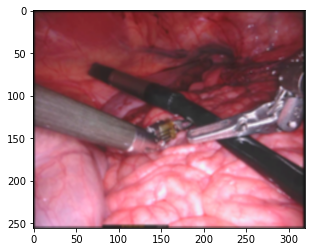

In [5]:
a,b,b0,c = next(iter(train_dataloader))
print(f"Data shape: {a.shape}")
print(f"Mask shape: {b.shape}")
print(f"Pred shape: {b0.shape}")
print(f"Path: {c}")
img = a[0][0].permute(1,2,0)
plt.imshow(img)

## Model

In [6]:
class CNNBackbone(nn.Module):
    def __init__(self, model="resnet101", pretrained=True):
        super(CNNBackbone, self).__init__()
        self.model_name = model
        self.pretrained = pretrained
        if self.model_name == "resnet101" and pretrained:
            model = models.resnet101(pretrained=True)
            self.cnn = torch.nn.Sequential(*(list(model.children())[:-4])).eval()
        else:
            raise NotImplementedError("Please use some pretrained CNN models")
        for param in self.cnn.parameters():
            param.requires_grad = False
        
    def forward(self, x):
        y = self.cnn(x[0])
        out = y.unsqueeze(0)
        # out.shape = [batch_size, T, C, H, W] = [1, T, 1024, 16, 20]
        return out

In [7]:
class PositionalEncoding3D(nn.Module):
    """https://github.com/tatp22/multidim-positional-encoding/blob/master/positional_encodings/positional_encodings.py"""
    
    def __init__(self, channels=1024):
        super(PositionalEncoding3D, self).__init__()
        channels = int(np.ceil(channels/6)*2)
        if channels % 2:
            channels += 1
        self.channels = channels
        inv_freq = 1. / (10000 ** (torch.arange(0, channels, 2).float() / channels))
        self.register_buffer('inv_freq', inv_freq)

    def forward(self, tensor):
        # Input tensor shape: [batch_size, T, C, H, W] 
        """
        :param tensor: A 5d tensor of size (batch_size, x, y, z, ch)
        :return: Positional Encoding Matrix of size (batch_size, x, y, z, ch)
        """
        tensor = tensor.permute(0, 4, 3, 1, 2)
        if len(tensor.shape) != 5:
            raise RuntimeError("The input tensor has to be 5d!")

        batch_size, x, y, z, orig_ch = tensor.shape
        pos_x = torch.arange(x, device=tensor.device).type(self.inv_freq.type())
        pos_y = torch.arange(y, device=tensor.device).type(self.inv_freq.type())
        pos_z = torch.arange(z, device=tensor.device).type(self.inv_freq.type())
        sin_inp_x = torch.einsum("i,j->ij", pos_x, self.inv_freq)
        sin_inp_y = torch.einsum("i,j->ij", pos_y, self.inv_freq)
        sin_inp_z = torch.einsum("i,j->ij", pos_z, self.inv_freq)
        emb_x = torch.cat((sin_inp_x.sin(), sin_inp_x.cos()), dim=-1).unsqueeze(1).unsqueeze(1)
        emb_y = torch.cat((sin_inp_y.sin(), sin_inp_y.cos()), dim=-1).unsqueeze(1)
        emb_z = torch.cat((sin_inp_z.sin(), sin_inp_z.cos()), dim=-1)
        emb = torch.zeros((x,y,z,self.channels*3),device=tensor.device).type(tensor.type())
        emb[:,:,:,:self.channels] = emb_x
        emb[:,:,:,self.channels:2*self.channels] = emb_y
        emb[:,:,:,2*self.channels:] = emb_z
        out = emb[None,:,:,:,:orig_ch].repeat(batch_size, 1, 1, 1, 1)
        out = out.permute(0, 3, 4, 2, 1)
        return out

In [8]:
class SparseAttention(nn.Module):
    """Sparse Self Attention Module"""
    def __init__(self, in_dim=512):
        """The only iuput attribute is dimension"""
        super(SparseAttention, self).__init__()
        self.query_conv = nn.Conv3d(in_channels=in_dim, out_channels=in_dim//8, kernel_size=1)
        self.key_conv = nn.Conv3d(in_channels=in_dim, out_channels=in_dim//8, kernel_size=1)
        self.value_conv = nn.Conv3d(in_channels=in_dim, out_channels=in_dim, kernel_size=1)
        self.softmax = nn.Softmax(dim=4)
        self.gamma = nn.Parameter(torch.ones(1))
        self.affinity = torch.zeros(0)
        self.obj_affinity = torch.zeros(0)

    def forward(self, x, m):
        # Input tensor shape: [batch_size, T, channel, H, W] 
        # Permute x to : [batch_size, channel, H, W, T]
        x = x.permute(0, 2, 3, 4, 1)
        b, C, H, W, T = x.shape
        proj_query = self.query_conv(x)
        proj_query_H = proj_query.permute(0,3,4,1,2).contiguous().view(b*W*T,-1,H).permute(0,2,1) # [b*W*T,H,C]
        proj_query_W = proj_query.permute(0,2,4,1,3).contiguous().view(b*H*T,-1,W).permute(0,2,1) # [b*H*T,W,C]
        proj_query_T = proj_query.permute(0,2,3,1,4).contiguous().view(b*W*H,-1,T).permute(0,2,1) # [b*W*H,T,C]
        m_H = m.permute(0,3,4,1,2).contiguous().view(b*W*T,-1,H).permute(0,2,1) # [b*W*T,H,C]
        m_W = m.permute(0,2,4,1,3).contiguous().view(b*H*T,-1,W).permute(0,2,1) # [b*H*T,W,C]
        m_T = m.permute(0,2,3,1,4).contiguous().view(b*W*H,-1,T).permute(0,2,1) # [b*W*H,T,C]

        proj_key = self.key_conv(x)
        proj_key_H = proj_key.permute(0,3,4,1,2).contiguous().view(b*W*T,-1,H)      # [b*W*T,C,H]
        proj_key_W = proj_key.permute(0,2,4,1,3).contiguous().view(b*H*T,-1,W)      # [b*H*T,C,W]
        proj_key_T = proj_key.permute(0,2,3,1,4).contiguous().view(b*W*H,-1,T)      # [b*W*H,C,T]

        proj_value = self.value_conv(x)
        proj_value_H = proj_value.permute(0,3,4,1,2).contiguous().view(b*W*T,-1,H)      # [b*W*T,C,H]
        proj_value_W = proj_value.permute(0,2,4,1,3).contiguous().view(b*H*T,-1,W)      # [b*H*T,C,W]
        proj_value_T = proj_value.permute(0,2,3,1,4).contiguous().view(b*W*H,-1,T)      # [b*W*H,C,T]

        energy_H = torch.bmm(proj_query_H, proj_key_H).view(b,W,T,H,H).permute(0,3,1,2,4) # [b,H,W,T,H]
        energy_W = torch.bmm(proj_query_W, proj_key_W).view(b,H,T,W,W).permute(0,1,3,2,4) # [b,H,W,T,W]
        energy_T = torch.bmm(proj_query_T, proj_key_T).view(b,H,W,T,T)                    # [b,H,W,T,T]
        score = self.softmax(torch.cat([energy_H,energy_W,energy_T],4))         # [b,H,W,T,(H+W+T)]
        self.score = score.permute(0,4,3,1,2)  # [b,(H+W+T),T,H,W]
        
        att_H = score[:,:,:,:,0:H].permute(0,2,3,1,4).contiguous().view(b*W*T,H,H)      # [b*W*T,H,H]
        att_W = score[:,:,:,:,H:H+W].permute(0,1,4,2,3).contiguous().view(b*H*T,W,W)    # [b*H*T,W,W]
        att_T = score[:,:,:,:,H+W:].contiguous().view(b*H*W,T,T)                        # [b*H*W,T,T]

        out_H = torch.bmm(proj_value_H, att_H.permute(0,2,1)).view(b,W,T,-1,H).permute(0,3,4,1,2)
        out_W = torch.bmm(proj_value_W, att_W.permute(0,2,1)).view(b,H,T,-1,W).permute(0,3,1,4,2)
        out_T = torch.bmm(proj_value_T, att_T.permute(0,2,1)).view(b,H,W,-1,T).permute(0,3,1,2,4)

        # objaff_H = torch.bmm(m_H, att_H.permute(0,2,1)).view(b,W,T,-1,H).permute(0,3,4,1,2)
        # objaff_W = torch.bmm(m_H, att_W.permute(0,2,1)).view(b,H,T,-1,W).permute(0,3,1,4,2)
        # objaff_T = torch.bmm(m_H, att_T.permute(0,2,1)).view(b,H,W,-1,T).permute(0,3,1,2,4)
        objaff_H = torch.mul(att_H, m_H).view(b,W,T,-1,H).permute(0,3,4,1,2)
        objaff_W = torch.mul(att_W, m_W).view(b,H,T,-1,W).permute(0,3,1,4,2)
        objaff_T = torch.mul(att_T, m_T).view(b,H,W,-1,T).permute(0,3,1,2,4)
        
        # permute back to [batch_size, T, channel, H, W] 
        output = self.gamma*(out_H + out_T + out_W).permute(0,4,1,2,3)
        objaff = torch.cat([objaff_H, objaff_W, objaff_T], 1)
        objaff = torch.max(objaff, dim=1).values.permute(0,3,1,2)
        self.obj_affinity = objaff

        return output

In [9]:
class SSTEncoder(nn.Module):
    """Define the Multi-head attention -> Add&Norm -> Feed Forward -> Add&Norm module"""
    def __init__(self, dim=512, dropout=0.5):
        super(SSTEncoder, self).__init__()

        # Multi-head attention sub-layer
        self.attn = SparseAttention(dim)
        self.norm_1 = nn.LayerNorm(dim)
        
        # Feed forward sub-layer
        self.fc = nn.Sequential(
            nn.Linear(in_features=dim, out_features=dim*2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(in_features=dim*2, out_features=dim)
        )
        self.norm_2 =  nn.LayerNorm(dim)
    
    def forward(self, x, m):
        y1 = self.attn(x, m)
        x2 = (x+y1).permute(0,3,4,1,2)   # permute from [b,T,C,H,W] to [b,H,W,T,C]
        y2 = self.norm_1(x2)
        y3 = self.fc(y2)
        out = self.norm_2(y2+y3).permute(0,3,4,1,2)  # permute from [b,H,W,T,C] to [b,T,C,H,W]

        return out

In [10]:
class DecoderBlock(nn.Module):
    """Define Decoder block for deconvolution"""
    def __init__(self, in_channels, mid_channels, out_channels, deconv=True):
        super(DecoderBlock, self).__init__()
        # self.in_channels = in_channels
        if deconv:
            self.Deblock = nn.Sequential(
                nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(mid_channels),
                nn.ReLU(),
                nn.ConvTranspose2d(mid_channels, out_channels, kernel_size=4, stride=2, padding=1),
                nn.BatchNorm2d(out_channels),
                
            )
        else:
            self.Deblock = nn.Sequential(
                nn.Upsample(scale_factor=2, mode='bilinar'),
                nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            )
    
    def forward(self, x):
        x = x.squeeze(0)
        y = self.Deblock(x)
        y = y.unsqueeze(0)
        return y

In [11]:
class Upscaler1x1Conv(nn.Module):
    """Perform 1x1 convolution to tune the channel first, then perform upsampling"""
    def __init__(self, in_channels, out_channels, scale):
        super(Upscaler1x1Conv, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels,kernel_size=1,stride=1,padding=0)
        self.scale = scale

    def forward(self, x):
        x = x.squeeze(0)
        y = self.conv1(x)
        y = F.interpolate(y,scale_factor=self.scale,mode='bilinear',align_corners=True)
        y = y.unsqueeze(0)
        return y

In [14]:
class MyTransformer(nn.Module):
    def __init__(self, num_layers=4):
        super(MyTransformer, self).__init__()

        self.backbone = CNNBackbone()
        self.pos_encoding = PositionalEncoding3D()
        self.self_attn1 = SSTEncoder()
        self.self_attn2 = SSTEncoder()
        self.self_attn3 = SSTEncoder()


        self.dec1 = DecoderBlock(512*2+3*1,1024,512)
        self.dec2 = DecoderBlock(1024,512,256)
        self.dec3 = DecoderBlock(512,256,1)
        self.conv1 = Upscaler1x1Conv(512*2+3,512,2)
        self.conv2 = Upscaler1x1Conv(512*2+3,256,4)
        # self.dec4 = DecoderBlock(128,64,8)
        self.cnn_feat = torch.zeros(1)
        self.encod_feat = torch.zeros(1)
        self.attn_scores = torch.zeros(1)
        self.object_affinity = torch.zeros(1)
    

    def save_preds(self, z, loc=""):
        """Save the predicted mask to file."""
        path = loc.replace("images","prediction_temp").replace(".jpg",".pt")
        z = F.interpolate(z.squeeze(0).float(), size=(32,40), mode='bilinear', align_corners=True)
        preds = torch.sigmoid(z[0]) > 0.5
        preds = preds.to(torch.float32).cpu()
        torch.save(preds, path)


    def forward(self, x, m, loc=""):
        """
        x - input frames sequence;
        loc - path of the last frame
        """
        # 1. subtract feature embedding from CNN backbone [b,T,C,H',W']
        cnn_fs = self.backbone(x)
        self.cnn_feat = cnn_fs
        # Get positional encoding and add it to the feature embedding
        pe = self.pos_encoding(cnn_fs)
        y = pe + cnn_fs

        # 2. Encoded feature from transformer layers 
        y1 = self.self_attn1(y, m)
        y2 = self.self_attn2(y1, m)
        y3 = self.self_attn3(y2, m)
        trans_feat = y1 + y2 + y3
        self.encod_feat = trans_feat
        
        # # 3. Object Affinity Value [N_layers,Obj,T,H',W']:
        affinity1 = self.self_attn1.attn.obj_affinity
        affinity2 = self.self_attn2.attn.obj_affinity
        affinity3 = self.self_attn3.attn.obj_affinity
        object_affinity = torch.stack([affinity1, affinity2, affinity3], 0)
        object_affinity = object_affinity.flatten(0,1).transpose(0,1).unsqueeze(0)
        self.object_affinity = object_affinity
        # # Adjust to [b,T,C,H',W']

        # Concatnate feature together
        emb = torch.cat([cnn_fs, trans_feat, object_affinity],dim=2)
        skip1 = self.conv1(emb)
        skip2 = self.conv2(emb)
        z = self.dec1(emb)
        z = self.dec2(torch.cat([z,skip1],2))
        z = self.dec3(torch.cat([z,skip2],2))
        # z = self.dec4(z)
        self.save_preds(z, loc)
        output = F.interpolate(z[-1],scale_factor=4,mode='bilinear',align_corners=True)
        return output

In [15]:
model = MyTransformer()
model.eval()
model = model.to(device)
z = model(a.to(device), b0.to(device), c[0])
z.shape

torch.Size([5, 1, 1024, 1280])

## Train

In [16]:
def get_jaccard(y_true, y_pred):
    intersection = (y_true * y_pred).sum()
    union = y_true.sum() + y_pred.sum() - intersection
    res = (intersection + 1e-15) / (union + 1e-15)
    return res.detach().cpu().numpy()


def get_Dice(y_true, y_pred):
    res = (2 * (y_true * y_pred).sum() + 1e-15) / (y_true.sum() + y_pred.sum() + 1e-15)
    return res.detach().cpu().numpy()

In [20]:
def train(model, train_dataloader, valid_dataloader, criterion, optimizer, epochs):
    # Initialize lists to store loss and fscore each epoch
    LOSS_train = []
    LOSS_valid = []
    Jaccard_train = []
    Jaccard_valid = []  
    Dice_train = []
    Dice_valid = []

    for epoch in tqdm.trange(epochs, desc="Epochs"):
        result = []
        train_loss = 0.0
        train_Jaccard = 0.0
        train_dice = 0.0
        valid_loss = 0.0
        valid_Jaccard = 0.0
        valid_dice = 0.0

        # Begin training
        model.train()
        for data, mask, temp, path in train_dataloader:
            data, mask, temp, path = data.to(device), mask.float().to(device), temp.to(device), path[0]
            output = model(data, temp, path)                            # Forward Passing
            target = mask.transpose(0,1)
            loss = criterion(output[0], target[0])                  # Compute loss
            preds = torch.sigmoid(output) > 0.5            # Make prediction
            preds = preds.to(torch.float32) 
            loss.backward()                                 # Compute gradients
            optimizer.step()                                # Update the model parameters
            optimizer.zero_grad()                           # Clear the gradients
            train_loss += loss.item() * data.size(0)        # Compute training loss
            train_Jaccard += get_jaccard(target[0][0], preds[0][0])
            train_dice += get_Dice(target[0][0], preds[0][0])

        # Begin validation
        model.eval()
        for data, mask, temp, path in valid_dataloader:
            data, mask, temp, path = data.to(device), mask.float().to(device), temp.to(device), path[0]
            output = model(data, temp, path)                             # Forward Passing
            target = mask.transpose(0,1)
            loss = criterion(output[0], target[0])                  # Compute loss
            preds = torch.sigmoid(output) > 0.5            # Make prediction
            preds = preds.to(torch.float32) 
            valid_loss += loss.item() * data.size(0)        # Compute validation loss
            valid_Jaccard += get_jaccard(target[0][0], preds[0][0])
            valid_dice += get_Dice(target[0][0], preds[0][0])
        
        # Compute epoch loss and f1
        epoch_train_loss = train_loss / len(train_dataloader.dataset)
        epoch_train_Jaccard = train_Jaccard / len(train_dataloader.dataset)
        epoch_train_dice = train_dice / len(train_dataloader.dataset)
        epoch_valid_loss = valid_loss / len(valid_dataloader.dataset)
        epoch_valid_Jaccard = valid_Jaccard / len(valid_dataloader.dataset)
        epoch_valid_dice = valid_dice / len(valid_dataloader.dataset)

        torch.save(model, "C:/Users/Siyao/Downloads/EndoVis2017Data/models/1116_bin.pt")

        # Record epoch loss and f1 to the list
        LOSS_train.append(epoch_train_loss)
        LOSS_valid.append(epoch_valid_loss)
        Jaccard_train.append(epoch_train_Jaccard)
        Jaccard_valid.append(epoch_valid_Jaccard)   
        Dice_train.append(epoch_train_dice)
        Dice_valid.append(epoch_valid_dice)

        result.append(f'{epoch} TRAIN loss: {epoch_train_loss:.4f}, Jaccard: {epoch_train_Jaccard:.4f}, Dice: {epoch_train_dice:.4f};  VALID loss: {epoch_valid_loss:.4f}, Jaccard: {epoch_valid_Jaccard:.4f}, Dice: {epoch_valid_dice:.4f}')

        print(result)
    return LOSS_train, LOSS_valid, Jaccard_train, Jaccard_valid, Dice_train, Dice_valid

In [ ]:
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        bce = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = bce + dice_loss
        
        return Dice_BCE

In [22]:
model = MyTransformer()
model = model.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
LOSS_train, LOSS_valid, Jaccard_train, Jaccard_valid, Dice_train, Dice_valid = train(model, train_dataloader, test_dataloader, criterion, optimizer, epochs=10)

Epochs:  10%|█         | 1/10 [16:28<2:28:14, 988.26s/it]

['0 TRAIN loss: 0.1254, Jaccard: 0.6881, Dice: 0.7901;  VALID loss: 0.1798, Jaccard: 0.6475, Dice: 0.7699']


Epochs:  20%|██        | 2/10 [32:56<2:11:47, 988.50s/it]

['1 TRAIN loss: 0.0827, Jaccard: 0.7660, Dice: 0.8540;  VALID loss: 0.1174, Jaccard: 0.7197, Dice: 0.8247']


Epochs:  30%|███       | 3/10 [49:29<1:55:32, 990.30s/it]

['2 TRAIN loss: 0.0679, Jaccard: 0.8007, Dice: 0.8770;  VALID loss: 0.0902, Jaccard: 0.7672, Dice: 0.8585']


Epochs:  40%|████      | 4/10 [1:06:18<1:39:45, 997.55s/it]

['3 TRAIN loss: 0.0603, Jaccard: 0.8230, Dice: 0.8930;  VALID loss: 0.0915, Jaccard: 0.7703, Dice: 0.8598']


Epochs:  50%|█████     | 5/10 [1:22:52<1:23:02, 996.41s/it]

['4 TRAIN loss: 0.0557, Jaccard: 0.8335, Dice: 0.8989;  VALID loss: 0.0743, Jaccard: 0.7981, Dice: 0.8801']


Epochs:  60%|██████    | 6/10 [1:39:26<1:06:21, 995.47s/it]

['5 TRAIN loss: 0.0491, Jaccard: 0.8510, Dice: 0.9106;  VALID loss: 0.0759, Jaccard: 0.7950, Dice: 0.8776']


Epochs:  70%|███████   | 7/10 [1:55:58<49:43, 994.56s/it]  

['6 TRAIN loss: 0.0438, Jaccard: 0.8652, Dice: 0.9202;  VALID loss: 0.0781, Jaccard: 0.7911, Dice: 0.8740']


Epochs:  80%|████████  | 8/10 [2:12:32<33:08, 994.44s/it]

['7 TRAIN loss: 0.0395, Jaccard: 0.8751, Dice: 0.9260;  VALID loss: 0.0626, Jaccard: 0.8244, Dice: 0.8976']


Epochs:  90%|█████████ | 9/10 [2:29:03<16:33, 993.16s/it]

['8 TRAIN loss: 0.0364, Jaccard: 0.8839, Dice: 0.9314;  VALID loss: 0.0778, Jaccard: 0.8058, Dice: 0.8838']


Epochs: 100%|██████████| 10/10 [2:45:54<00:00, 995.45s/it]

['9 TRAIN loss: 0.0353, Jaccard: 0.8862, Dice: 0.9326;  VALID loss: 0.0644, Jaccard: 0.8180, Dice: 0.8929']


In [23]:
torch.save(model, "C:/Users/Siyao/Downloads/EndoVis2017Data/models/1116_bin_10epochs.pt")

In [24]:
optimizer = optim.Adam(model.parameters(), lr=0.0001)
LOSS_train, LOSS_valid, Jaccard_train, Jaccard_valid, Dice_train, Dice_valid = train(model, train_dataloader, test_dataloader, criterion, optimizer, epochs=3)

Epochs:  33%|███▎      | 1/3 [17:14<34:29, 1034.99s/it]

['0 TRAIN loss: 0.0415, Jaccard: 0.8670, Dice: 0.9199;  VALID loss: 0.0876, Jaccard: 0.7820, Dice: 0.8669']


Epochs:  67%|██████▋   | 2/3 [34:20<17:09, 1029.42s/it]

['1 TRAIN loss: 0.0348, Jaccard: 0.8856, Dice: 0.9315;  VALID loss: 0.0930, Jaccard: 0.7823, Dice: 0.8667']


Epochs: 100%|██████████| 3/3 [51:21<00:00, 1027.21s/it]

['2 TRAIN loss: 0.0326, Jaccard: 0.8918, Dice: 0.9357;  VALID loss: 0.0862, Jaccard: 0.8056, Dice: 0.8832']


In [25]:
LOSS_train, LOSS_valid, Jaccard_train, Jaccard_valid, Dice_train, Dice_valid = train(model, train_dataloader, test_dataloader, criterion, optimizer, epochs=5)

Epochs:  20%|██        | 1/5 [16:46<1:07:05, 1006.25s/it]

['0 TRAIN loss: 0.0317, Jaccard: 0.8960, Dice: 0.9387;  VALID loss: 0.0754, Jaccard: 0.8193, Dice: 0.8928']


Epochs:  40%|████      | 2/5 [33:32<50:18, 1006.10s/it]  

['1 TRAIN loss: 0.0308, Jaccard: 0.8989, Dice: 0.9406;  VALID loss: 0.0918, Jaccard: 0.7958, Dice: 0.8763']


Epochs:  60%|██████    | 3/5 [50:06<33:21, 1000.89s/it]

['2 TRAIN loss: 0.0301, Jaccard: 0.9005, Dice: 0.9414;  VALID loss: 0.0889, Jaccard: 0.8058, Dice: 0.8832']


Epochs:  80%|████████  | 4/5 [1:05:58<16:21, 981.47s/it]

['3 TRAIN loss: 0.0290, Jaccard: 0.9033, Dice: 0.9433;  VALID loss: 0.0881, Jaccard: 0.8063, Dice: 0.8840']


Epochs: 100%|██████████| 5/5 [1:21:45<00:00, 981.09s/it]

['4 TRAIN loss: 0.0282, Jaccard: 0.9061, Dice: 0.9451;  VALID loss: 0.1147, Jaccard: 0.7767, Dice: 0.8623']


In [26]:
torch.save(model, "C:/Users/Siyao/Downloads/EndoVis2017Data/models/1116_bin_15epochs.pt")

In [27]:
LOSS_train, LOSS_valid, Jaccard_train, Jaccard_valid, Dice_train, Dice_valid = train(model, train_dataloader, test_dataloader, criterion, optimizer, epochs=5)

Epochs:  20%|██        | 1/5 [15:50<1:03:20, 950.11s/it]

['0 TRAIN loss: 0.0280, Jaccard: 0.9057, Dice: 0.9443;  VALID loss: 0.0680, Jaccard: 0.8274, Dice: 0.8994']


Epochs:  40%|████      | 2/5 [32:02<48:10, 963.39s/it]  

['1 TRAIN loss: 0.0271, Jaccard: 0.9078, Dice: 0.9455;  VALID loss: 0.0824, Jaccard: 0.8077, Dice: 0.8856']


Epochs:  60%|██████    | 3/5 [48:13<32:13, 966.57s/it]

['2 TRAIN loss: 0.0268, Jaccard: 0.9084, Dice: 0.9456;  VALID loss: 0.0771, Jaccard: 0.8201, Dice: 0.8937']


Epochs:  80%|████████  | 4/5 [1:03:56<15:57, 957.48s/it]

['3 TRAIN loss: 0.0264, Jaccard: 0.9109, Dice: 0.9479;  VALID loss: 0.0833, Jaccard: 0.8079, Dice: 0.8855']


Epochs: 100%|██████████| 5/5 [1:19:45<00:00, 957.01s/it]

['4 TRAIN loss: 0.0260, Jaccard: 0.9131, Dice: 0.9497;  VALID loss: 0.0844, Jaccard: 0.8080, Dice: 0.8859']


In [28]:
torch.save(model, "C:/Users/Siyao/Downloads/EndoVis2017Data/models/1116_bin_20epochs.pt")

In [29]:
LOSS_train, LOSS_valid, Jaccard_train, Jaccard_valid, Dice_train, Dice_valid = train(model, train_dataloader, test_dataloader, criterion, optimizer, epochs=10)

Epochs:  10%|█         | 1/10 [15:43<2:21:35, 943.98s/it]

['0 TRAIN loss: 0.0257, Jaccard: 0.9132, Dice: 0.9494;  VALID loss: 0.0864, Jaccard: 0.8080, Dice: 0.8856']


Epochs:  20%|██        | 2/10 [31:28<2:05:56, 944.52s/it]

['1 TRAIN loss: 0.0254, Jaccard: 0.9156, Dice: 0.9514;  VALID loss: 0.0767, Jaccard: 0.8164, Dice: 0.8916']


Epochs:  30%|███       | 3/10 [47:14<1:50:15, 945.00s/it]

['2 TRAIN loss: 0.0248, Jaccard: 0.9158, Dice: 0.9511;  VALID loss: 0.0929, Jaccard: 0.8108, Dice: 0.8862']


Epochs:  40%|████      | 4/10 [1:03:00<1:34:31, 945.24s/it]

['3 TRAIN loss: 0.0245, Jaccard: 0.9172, Dice: 0.9518;  VALID loss: 0.0780, Jaccard: 0.8211, Dice: 0.8944']


Epochs:  50%|█████     | 5/10 [1:18:44<1:18:44, 944.96s/it]

['4 TRAIN loss: 0.0241, Jaccard: 0.9185, Dice: 0.9527;  VALID loss: 0.0706, Jaccard: 0.8274, Dice: 0.8993']


Epochs:  60%|██████    | 6/10 [1:34:30<1:03:01, 945.36s/it]

['5 TRAIN loss: 0.0238, Jaccard: 0.9203, Dice: 0.9543;  VALID loss: 0.0738, Jaccard: 0.8213, Dice: 0.8953']


Epochs:  70%|███████   | 7/10 [1:50:16<47:16, 945.42s/it]  

['6 TRAIN loss: 0.0236, Jaccard: 0.9213, Dice: 0.9549;  VALID loss: 0.0638, Jaccard: 0.8361, Dice: 0.9056']


Epochs:  80%|████████  | 8/10 [2:06:17<31:40, 950.34s/it]

['7 TRAIN loss: 0.0233, Jaccard: 0.9199, Dice: 0.9533;  VALID loss: 0.0572, Jaccard: 0.8470, Dice: 0.9126']


Epochs:  90%|█████████ | 9/10 [2:22:28<15:56, 956.97s/it]

['8 TRAIN loss: 0.0227, Jaccard: 0.9246, Dice: 0.9572;  VALID loss: 0.0674, Jaccard: 0.8369, Dice: 0.9056']


Epochs: 100%|██████████| 10/10 [2:38:17<00:00, 949.73s/it]

['9 TRAIN loss: 0.0225, Jaccard: 0.9239, Dice: 0.9563;  VALID loss: 0.0609, Jaccard: 0.8431, Dice: 0.9098']


In [30]:
torch.save(model, "C:/Users/Siyao/Downloads/EndoVis2017Data/models/1116_bin_30epochs.pt")

In [73]:
LOSS_train, LOSS_valid, Jaccard_train, Jaccard_valid, Dice_train, Dice_valid = train(model, train_dataloader, test_dataloader, criterion, optimizer, epochs=10)

Epochs:  10%|█         | 1/10 [17:31<2:37:41, 1051.32s/it]

['0 TRAIN loss: 0.0224, Jaccard: 0.9239, Dice: 0.9561;  VALID loss: 0.0706, Jaccard: 0.8316, Dice: 0.9018']


Epochs:  20%|██        | 2/10 [34:21<2:16:58, 1027.27s/it]

['1 TRAIN loss: 0.0221, Jaccard: 0.9246, Dice: 0.9565;  VALID loss: 0.0952, Jaccard: 0.8115, Dice: 0.8870']


Epochs:  30%|███       | 3/10 [51:07<1:58:42, 1017.50s/it]

['2 TRAIN loss: 0.0218, Jaccard: 0.9263, Dice: 0.9579;  VALID loss: 0.0713, Jaccard: 0.8293, Dice: 0.9003']


Epochs:  40%|████      | 4/10 [1:08:04<1:41:43, 1017.20s/it]

['3 TRAIN loss: 0.0215, Jaccard: 0.9283, Dice: 0.9594;  VALID loss: 0.0712, Jaccard: 0.8381, Dice: 0.9059']


Epochs:  50%|█████     | 5/10 [1:24:42<1:24:11, 1010.36s/it]

['4 TRAIN loss: 0.0217, Jaccard: 0.9244, Dice: 0.9557;  VALID loss: 0.0691, Jaccard: 0.8351, Dice: 0.9046']


Epochs:  60%|██████    | 6/10 [1:41:33<1:07:22, 1010.54s/it]

['5 TRAIN loss: 0.0213, Jaccard: 0.9283, Dice: 0.9592;  VALID loss: 0.0675, Jaccard: 0.8401, Dice: 0.9079']


Epochs:  70%|███████   | 7/10 [1:58:35<50:42, 1014.16s/it]  

['6 TRAIN loss: 0.0209, Jaccard: 0.9300, Dice: 0.9604;  VALID loss: 0.0642, Jaccard: 0.8411, Dice: 0.9085']


Epochs:  80%|████████  | 8/10 [2:15:16<33:40, 1010.04s/it]

['7 TRAIN loss: 0.0205, Jaccard: 0.9318, Dice: 0.9617;  VALID loss: 0.0828, Jaccard: 0.8268, Dice: 0.8978']


Epochs:  90%|█████████ | 9/10 [2:31:24<16:37, 997.07s/it] 

['8 TRAIN loss: 0.0202, Jaccard: 0.9336, Dice: 0.9632;  VALID loss: 0.0772, Jaccard: 0.8335, Dice: 0.9026']


Epochs: 100%|██████████| 10/10 [2:47:54<00:00, 1007.47s/it]

['9 TRAIN loss: 0.0203, Jaccard: 0.9316, Dice: 0.9612;  VALID loss: 0.0829, Jaccard: 0.8226, Dice: 0.8954']


In [74]:
torch.save(model, "C:/Users/Siyao/Downloads/EndoVis2017Data/models/1116_bin_40epochs.pt")

In [75]:
LOSS_train, LOSS_valid, Jaccard_train, Jaccard_valid, Dice_train, Dice_valid = train(model, train_dataloader, test_dataloader, criterion, optimizer, epochs=5)

Epochs:  20%|██        | 1/5 [15:56<1:03:44, 956.17s/it]

['0 TRAIN loss: 0.0202, Jaccard: 0.9331, Dice: 0.9626;  VALID loss: 0.0698, Jaccard: 0.8355, Dice: 0.9043']


Epochs:  40%|████      | 2/5 [32:46<49:23, 987.82s/it]  

['1 TRAIN loss: 0.0201, Jaccard: 0.9330, Dice: 0.9624;  VALID loss: 0.0600, Jaccard: 0.8444, Dice: 0.9109']


Epochs:  60%|██████    | 3/5 [50:02<33:39, 1009.99s/it]

['2 TRAIN loss: 0.0197, Jaccard: 0.9317, Dice: 0.9606;  VALID loss: 0.0746, Jaccard: 0.8326, Dice: 0.9023']


Epochs:  80%|████████  | 4/5 [1:06:59<16:52, 1012.90s/it]

['3 TRAIN loss: 0.0197, Jaccard: 0.9334, Dice: 0.9623;  VALID loss: 0.0651, Jaccard: 0.8407, Dice: 0.9081']


Epochs: 100%|██████████| 5/5 [1:24:41<00:00, 1016.32s/it]

['4 TRAIN loss: 0.0193, Jaccard: 0.9331, Dice: 0.9614;  VALID loss: 0.0731, Jaccard: 0.8364, Dice: 0.9050']


In [76]:
def get_mask(img, tmp, pth):
    model.eval()
    img, tmp, pth = img.to(device), tmp.to(device), pth[0]
    output = model(img, tmp, pth)     
    preds = torch.sigmoid(output) > 0.5             
    preds = preds.float()
    return preds.detach().cpu()

In [107]:
frame,mask,pred,c = train_dataset[687]
# img = a[0][0].permute(1,2,0)
# plt.imshow(img)
frame = frame.unsqueeze(0)
mask = mask.unsqueeze(0)
pred = pred.unsqueeze(0) 
print(f"Data shape: {frame.shape}")
print(f"Mask shape: {mask.shape}")
print(f"Path: {c}")

Data shape: torch.Size([1, 5, 3, 256, 320])
Mask shape: torch.Size([1, 5, 1024, 1280])
Path: C:\Users\Siyao\Downloads\EndoVis2017Data\cropped_train\instrument_dataset_4\images\frame028.jpg


In [108]:
prd = get_mask(frame, pred, c)
prd.shape

torch.Size([5, 1, 1024, 1280])

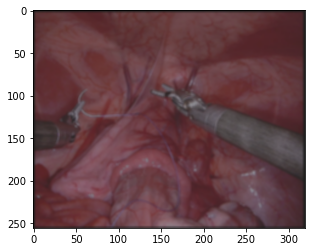

In [109]:
plt.imshow(frame[0][0].permute(1,2,0))

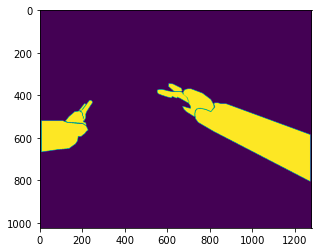

In [110]:
plt.imshow(mask[0][0])

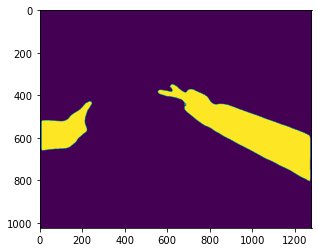

In [111]:
plt.imshow(prd[0][0])

In [60]:
def mask_overlay(image, mask, color=(0, 255, 0)):
    """
    Helper function to visualize mask on the top of the car
    """
    mask = np.dstack((mask, mask, mask)) * np.array(color)
    mask = mask.astype(np.uint8)
    weighted_sum = cv2.addWeighted(mask, 0.5, image, 0.5, 0.)
    img = image.copy()
    ind = mask[:, :, 1] > 0    
    img[ind] = weighted_sum[ind]    
    return img

In [71]:
img = np.array(frame[0][0])
mask = np.array(prd[0][0])

In [72]:
ret = mask_overlay(img, mask)

error: OpenCV(4.5.3) C:\Users\runneradmin\AppData\Local\Temp\pip-req-build-z4706ql7\opencv\modules\core\src\arithm.cpp:650: error: (-209:Sizes of input arguments do not match) The operation is neither 'array op array' (where arrays have the same size and the same number of channels), nor 'array op scalar', nor 'scalar op array' in function 'cv::arithm_op'


In [64]:
plt.imshow(mask_overlay(frame[0][0], prd[0][0]).astype(np.uint8))

error: OpenCV(4.5.3) :-1: error: (-5:Bad argument) in function 'addWeighted'
> Overload resolution failed:
>  - src2 is not a numpy array, neither a scalar
>  - Expected Ptr<cv::UMat> for argument 'src2'
